# Predicting Market Demand
My stakeholders want to use some market data to make a business decision. However, the key factor in the market data has a lot of missing values in it. 

In this exercise, I built a Linear Regression model with some data pre-processing such as: 
* Data cleaning and removing outliers
* Scaling
* SelectKBest and PCA for feature selection


# Challenge
There is a challenge in this exercise and that is a lack of data. As you will see, I only have around 70 data points to train my model with, and that goes down even further with train-test-split. With the model, I will need to "fill in" around 120 data gaps with my model's prediction. The goal is to try my best to reduce the features needed to train the model as much as possible while at the same time prevent overfitting by leaving some data for testing purposes

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('notebook')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import feature_selection
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
import copy

In [2]:
raw_df = pd.read_excel('Market Data.xlsx')

# Data Cleaning

In [3]:
# I am removing Qatar because it's an extreme outlier in the model fitting
raw_df.drop(raw_df[raw_df['Country'] == 'Qatar'].index[0],inplace=True)

In [4]:
print 'Number of observations:',len(raw_df)
print 'Number of gaps I have to fill:', len(raw_df[np.isnan(raw_df['Factor 8 IU per capita'])])
raw_df.head(1)

Number of observations: 209
Number of gaps I have to fill: 137


,Market,Country,"Births per 1,000 Population","Deaths per 1,000 Population","Net Migration Rate per 1,000",Population mid-2015 (millions),Population mid-2030,Population mid-2050,Infant Mortality Ratea,Total Fertility Rateb,...,Factor 8 IU per capita,All factor 8 (IU total),Percent plasma dervied,Plasma derived factor 8 (IU total),2015 Shire sales (IU total),Growth Rate,Population 2020 (millions),Population 2020,Prevalence,People with Hemo 2020
0,N,Afghanistan,34,8,2,32.2,45.8,64.3,74,4.9,...,0.009,300000.0,0.0,No data,NaN,0.023766,36.212547,3.621255e+07,NaN,NaN


In [5]:
raw_df.isnull().sum()

Market                                  0
Country                                 0
Births per 1,000 Population             0
Deaths per 1,000 Population             0
Net Migration Rate per 1,000            0
Population mid-2015 (millions)          0
Population mid-2030                     0
Population mid-2050                     0
Infant Mortality Ratea                  0
Total Fertility Rateb                   0
Percent of population < 15 years        0
Percent of population > 65 years        0
GNI per Capita ($US) 2014c             23
Percent Urban                           0
Calculated Hemophilia Population       64
Survey Hemophilia Population          111
Factor 8 IU per capita                137
All factor 8 (IU total)               142
Percent plasma dervied                137
Plasma derived factor 8 (IU total)    137
2015 Shire sales (IU total)           185
Growth Rate                             0
Population 2020 (millions)              0
Population 2020                   

There are some columns that are just missing too many data points. I can't use them in the model for sure, so the feature set is primarily limited by missing data points. I can't do an across the board dropna() because I will lose a large portion of my data.

When I was doing exploratory data analysis, I was interested in using the infant mortality rate, but it had several error values that needs to be cleaned, so I'm excluding this from the data set.

In [6]:
# China and India is throwing off my model with populataion 5x that of United States. 
raw_df.sort_values(by='Population mid-2015 (millions)', ascending=False).head()

,Market,Country,"Births per 1,000 Population","Deaths per 1,000 Population","Net Migration Rate per 1,000",Population mid-2015 (millions),Population mid-2030,Population mid-2050,Infant Mortality Ratea,Total Fertility Rateb,...,Factor 8 IU per capita,All factor 8 (IU total),Percent plasma dervied,Plasma derived factor 8 (IU total),2015 Shire sales (IU total),Growth Rate,Population 2020 (millions),Population 2020,Prevalence,People with Hemo 2020
36,N,China,12,7,0,1371.9,1422.5,1365.7,12,1.7,...,NaN,NaN,NaN,NaN,NaN,0.002418,1388.563449,1.388563e+09,0.000004,5554.253795
13,Y,India,21,7,-1,1314.1,1512.9,1660.1,42,2.3,...,0.004,4901353.0,98.0,4781353,70729594.0,0.009436,1377.280349,1.377280e+09,0.000011,15150.083844
200,N,United States,13,8,3,321.2,359.4,398.3,6,1.9,...,NaN,NaN,NaN,NaN,84384931.0,0.007520,333.459465,3.334595e+08,0.000078,26009.838246
85,N,Indonesia,21,6,-1,255.7,307.6,366.5,31,2.6,...,NaN,NaN,NaN,NaN,NaN,0.012396,271.945950,2.719460e+08,0.000001,271.945950
86,Y,Brazil,15,6,0,204.5,223.1,226.3,19,1.8,...,2.836,574812500.0,50.0,285150250,NaN,0.005820,210.520987,2.105210e+08,0.000064,13473.343194


In [7]:
# The following returns an error, so that means there's some invalid data, which I will remove later on.
# raw_df['Percent Urban'] = raw_df['Percent Urban'].apply(float)
# for i in raw_df['Infant Mortality Ratea'].index:
#     try:
#         float(raw_df['Infant Mortality Ratea'][i])
#     except:
#         print raw_df.ix[i]

## Dropping the Identified Problematic Observations

In [8]:
# The index to remove from the data set includes identified outliers and invalid data points
processed_df = copy.deepcopy(raw_df[~raw_df.index.isin([47,125, 36, 13])])
processed_df['Infant Mortality Ratea'] = processed_df['Infant Mortality Ratea'].apply(float)
len(processed_df)

205

In [9]:
processed_df.ix[:,:'Factor 8 IU per capita'].describe()

C:\Users\leungr1\AppData\Local\Continuum\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,"Births per 1,000 Population","Deaths per 1,000 Population","Net Migration Rate per 1,000",Population mid-2015 (millions),Population mid-2030,Population mid-2050,Infant Mortality Ratea,Total Fertility Rateb,Percent of population < 15 years,Percent of population > 65 years,GNI per Capita ($US) 2014c,Calculated Hemophilia Population,Survey Hemophilia Population,Factor 8 IU per capita
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,184.000000,143.000000,96.000000,71.000000
mean,21.760976,8.053659,-0.253659,22.667073,27.150585,33.043902,25.409268,2.877073,28.234146,8.287805,17329.619565,897.960350,1189.354167,2.102423
std,10.816946,3.117322,6.840913,43.546067,51.436118,63.005825,24.524141,1.462140,10.636314,5.734322,18564.739578,1611.738163,2070.293328,2.653504
min,7.000000,1.000000,-28.000000,0.010000,0.010000,0.020000,1.600000,1.200000,11.000000,1.000000,610.000000,0.160000,0.000000,0.000000
25%,12.000000,6.000000,-2.000000,1.300000,1.300000,1.400000,6.000000,1.700000,18.000000,4.000000,NaN,NaN,NaN,NaN
50%,19.000000,8.000000,0.000000,7.000000,8.300000,9.400000,16.000000,2.400000,27.000000,6.000000,NaN,NaN,NaN,NaN
75%,31.000000,10.000000,2.000000,23.500000,32.000000,38.300000,39.000000,3.900000,38.000000,13.000000,NaN,NaN,NaN,NaN
max,50.000000,20.000000,45.000000,321.200000,359.400000,398.300000,109.000000,7.600000,52.000000,26.000000,118460.000000,12848.000000,13010.000000,8.604000


In [10]:
# Further removing features that I know I won't use in the feature selection step
processed_df = processed_df.ix[:,:'Factor 8 IU per capita'].drop(['Calculated Hemophilia Population',
                                                                  'Survey Hemophilia Population',
                                                                   ],
                                                                  axis=1)
processed_df.describe()

,"Births per 1,000 Population","Deaths per 1,000 Population","Net Migration Rate per 1,000",Population mid-2015 (millions),Population mid-2030,Population mid-2050,Infant Mortality Ratea,Total Fertility Rateb,Percent of population < 15 years,Percent of population > 65 years,GNI per Capita ($US) 2014c,Factor 8 IU per capita
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,184.000000,71.000000
mean,21.760976,8.053659,-0.253659,22.667073,27.150585,33.043902,25.409268,2.877073,28.234146,8.287805,17329.619565,2.102423
std,10.816946,3.117322,6.840913,43.546067,51.436118,63.005825,24.524141,1.462140,10.636314,5.734322,18564.739578,2.653504
min,7.000000,1.000000,-28.000000,0.010000,0.010000,0.020000,1.600000,1.200000,11.000000,1.000000,610.000000,0.000000
25%,12.000000,6.000000,-2.000000,1.300000,1.300000,1.400000,6.000000,1.700000,18.000000,4.000000,NaN,NaN
50%,19.000000,8.000000,0.000000,7.000000,8.300000,9.400000,16.000000,2.400000,27.000000,6.000000,NaN,NaN
75%,31.000000,10.000000,2.000000,23.500000,32.000000,38.300000,39.000000,3.900000,38.000000,13.000000,NaN,NaN
max,50.000000,20.000000,45.000000,321.200000,359.400000,398.300000,109.000000,7.600000,52.000000,26.000000,118460.000000,8.604000


In [11]:
processed_df = processed_df.dropna(subset=['GNI per Capita ($US) 2014c'])

# Exploratory Data Analysis

In [12]:
print 'Observations left after cleaning:',len(processed_df)
print 'Observations available for training:',len(processed_df.dropna())
print processed_df.columns
processed_df.describe()

Observations left after cleaning: 184
Observations available for training: 70
Index([u'Market', u'Country', u'Births per 1,000 Population',
       u'Deaths per 1,000 Population', u'Net Migration Rate per 1,000',
       u'Population mid-2015 (millions)', u'Population mid-2030',
       u'Population mid-2050', u'Infant Mortality Ratea',
       u'Total Fertility Rateb', u'Percent of population < 15 years',
       u'Percent of population > 65 years', u'GNI per Capita ($US) 2014c',
       u'Percent Urban', u'Factor 8 IU per capita'],
      dtype='object')


,"Births per 1,000 Population","Deaths per 1,000 Population","Net Migration Rate per 1,000",Population mid-2015 (millions),Population mid-2030,Population mid-2050,Infant Mortality Ratea,Total Fertility Rateb,Percent of population < 15 years,Percent of population > 65 years,GNI per Capita ($US) 2014c,Factor 8 IU per capita
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,70.000000
mean,22.092391,8.195652,-0.021739,24.297228,29.137554,35.582228,26.143478,2.911413,28.532609,8.179348,17329.619565,2.081886
std,10.933837,3.175174,6.754037,45.414433,53.651127,65.755097,24.716099,1.485496,10.748441,5.756954,18564.739578,2.666974
min,7.000000,1.000000,-28.000000,0.010000,0.010000,0.020000,1.600000,1.200000,11.000000,1.000000,610.000000,0.000000
25%,12.000000,6.000000,-2.000000,2.000000,2.300000,2.500000,6.750000,1.700000,18.000000,3.000000,3935.000000,NaN
50%,20.000000,8.000000,0.000000,7.500000,8.900000,10.300000,17.000000,2.400000,28.000000,6.000000,11175.000000,NaN
75%,31.000000,10.000000,2.000000,24.175000,34.325000,41.925000,40.250000,4.100000,39.000000,13.000000,23877.500000,NaN
max,50.000000,20.000000,45.000000,321.200000,359.400000,398.300000,109.000000,7.600000,52.000000,26.000000,118460.000000,8.604000


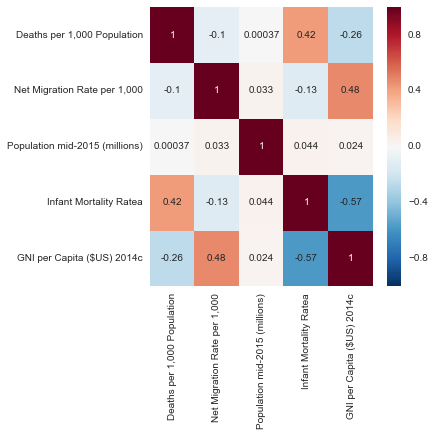

In [13]:
# Taking out the highly correlated features to avoid multi-collinearity
cols = [
#         'Births per 1,000 Population',
        'Deaths per 1,000 Population',
        'Net Migration Rate per 1,000',
        'Population mid-2015 (millions)', 
#         'Population mid-2030',
#         'Population mid-2050', 
        'Infant Mortality Ratea',
#         'Total Fertility Rateb', 
#         'Percent of population < 15 years',
#         'Percent of population > 65 years',
        'GNI per Capita ($US) 2014c',
        'Percent Urban'
        ]
plt.figure(figsize=(5,5))
sns.heatmap(data=processed_df[cols].corr(), annot=True)

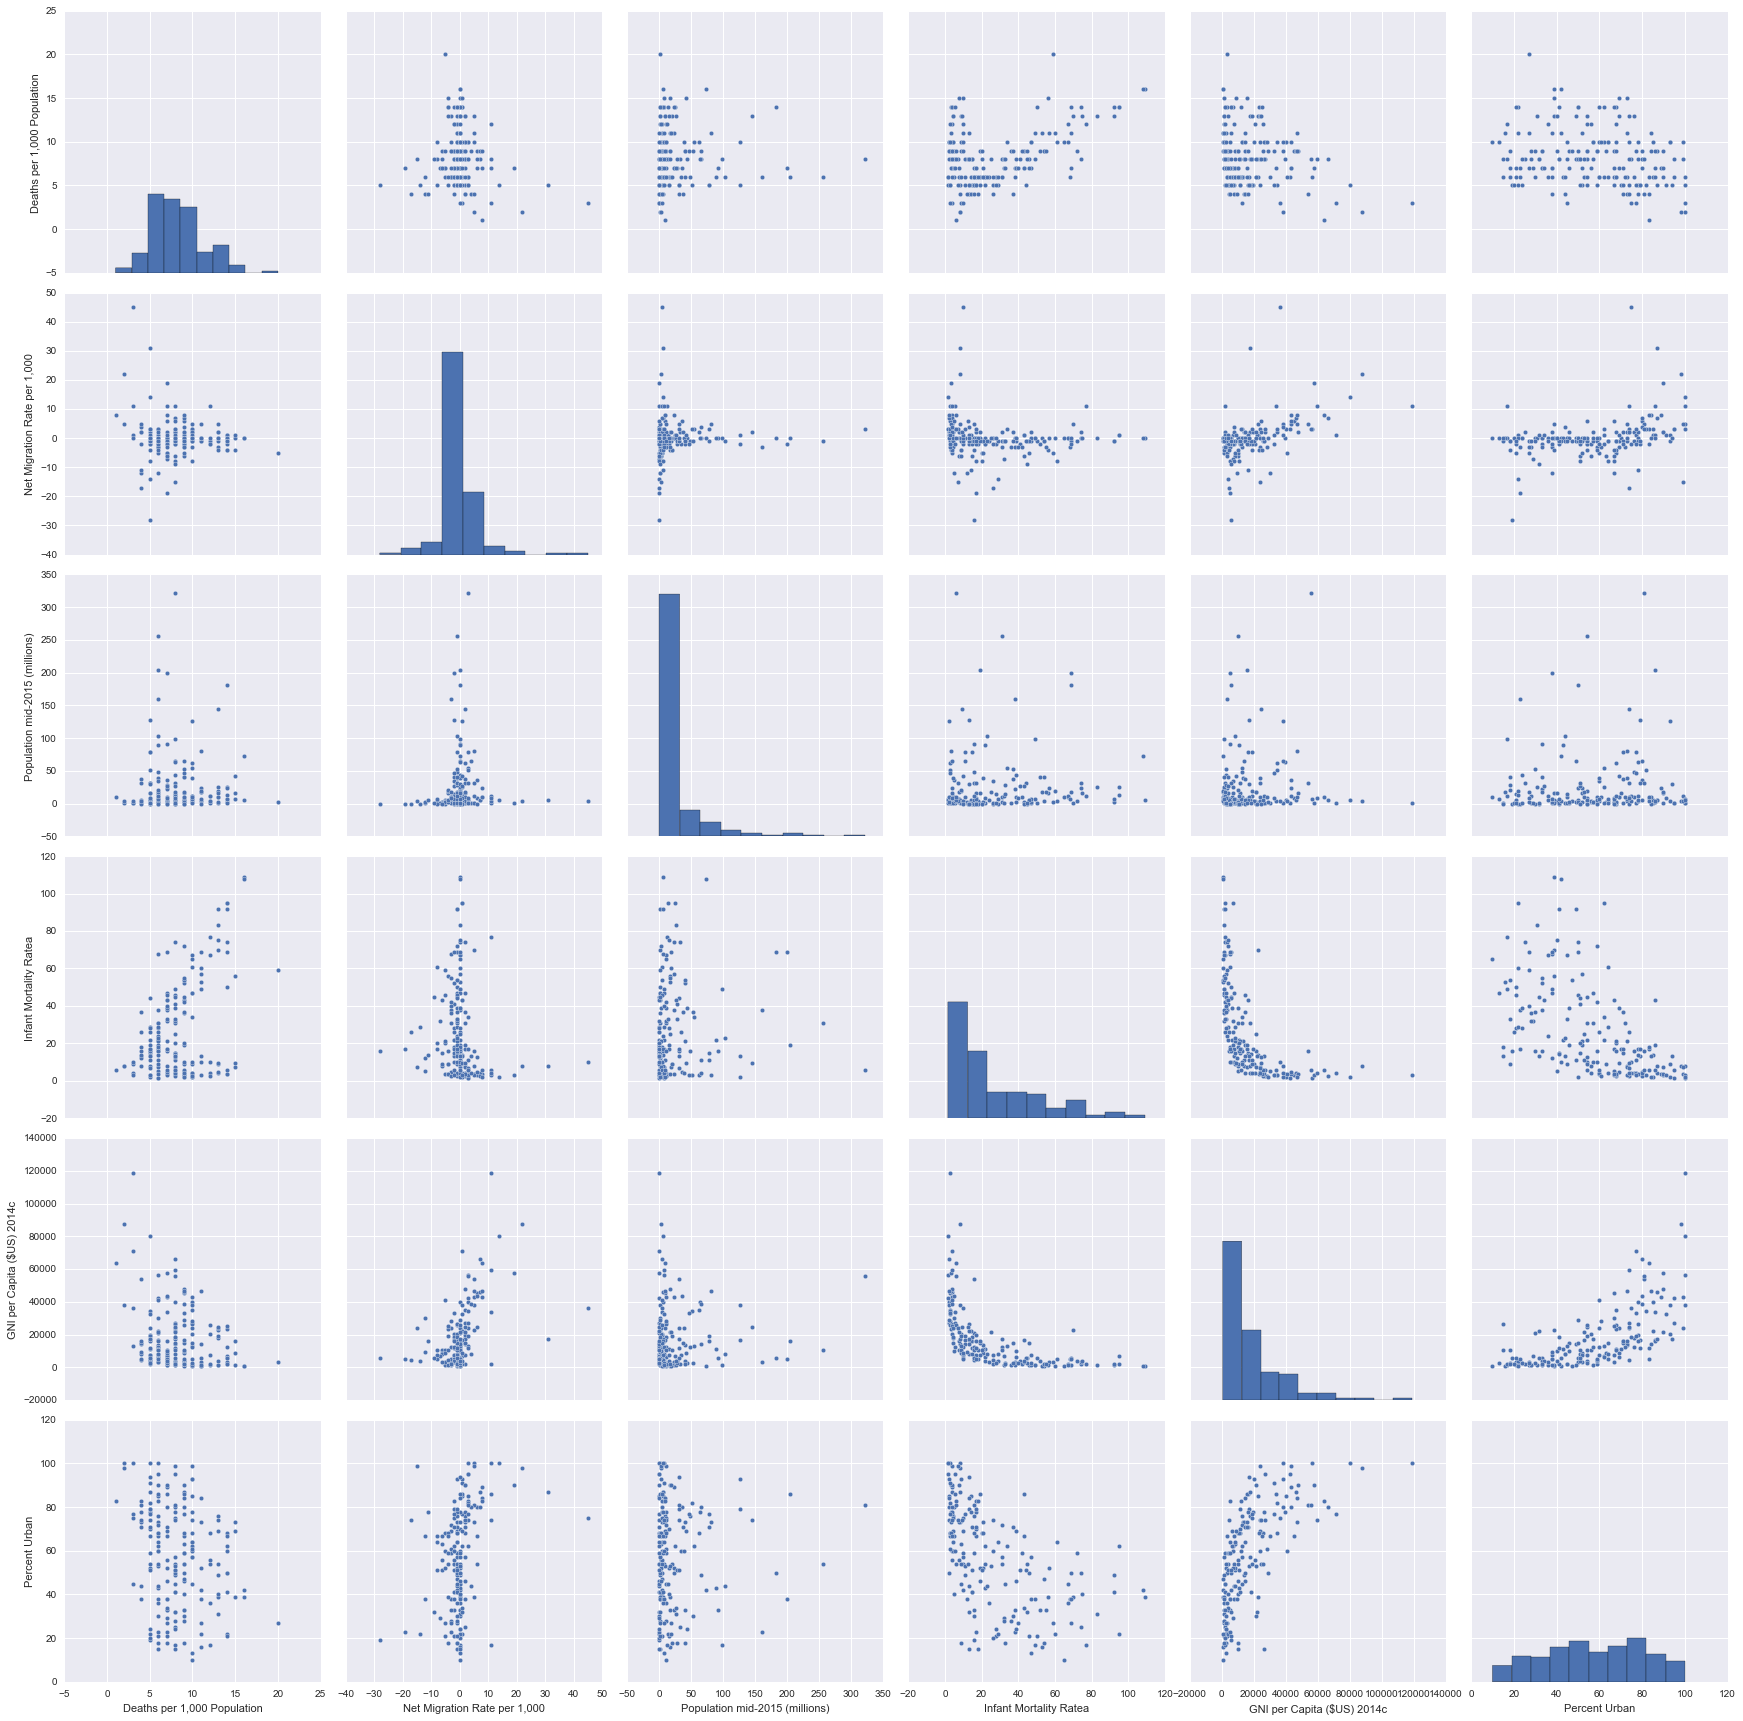

In [14]:
sns.pairplot(data=processed_df[cols], size = 4)

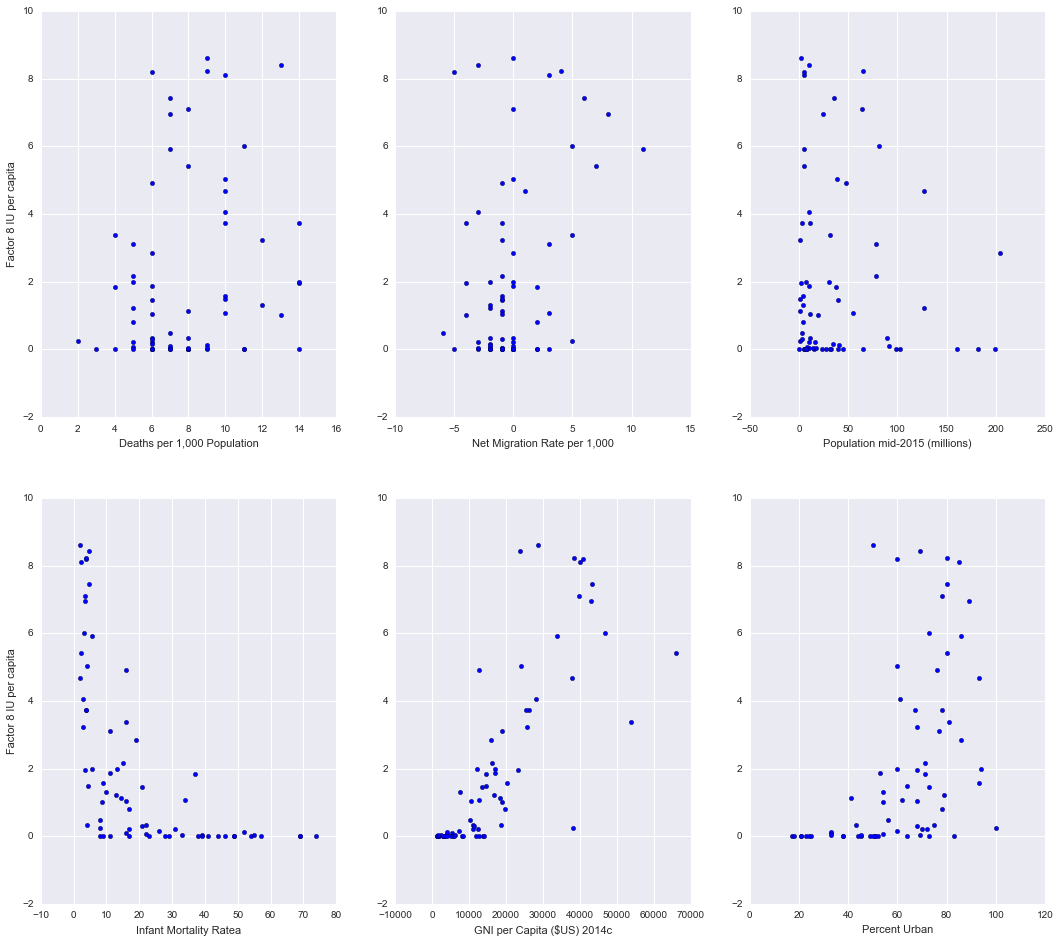

In [15]:
y = processed_df.dropna()['Factor 8 IU per capita']
figure, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,16))
axes[0,0].scatter(processed_df.dropna()[cols[0]],y)
axes[0,0].set_xlabel(cols[0])
axes[0,0].set_ylabel('Factor 8 IU per capita')
axes[0,1].scatter(processed_df.dropna()[cols[1]],y)
axes[0,1].set_xlabel(cols[1])
axes[0,2].scatter(processed_df.dropna()[cols[2]],y)
axes[0,2].set_xlabel(cols[2])
axes[1,0].scatter(processed_df.dropna()[cols[3]],y)
axes[1,0].set_xlabel(cols[3])
axes[1,0].set_ylabel('Factor 8 IU per capita')
axes[1,1].scatter(processed_df.dropna()[cols[4]],y)
axes[1,1].set_xlabel(cols[4])
axes[1,2].scatter(processed_df.dropna()[cols[5]],y)
axes[1,2].set_xlabel(cols[5])

Seems like Infant Mortality Rate is inversely related to our target. Let's create a new feature to make Infant Mortality Rate have a more linear relationship with the target.

# Feature Engineering
Modifying a feature that is more linearly aligned with the target.

In [16]:
processed_df['Inverse Infant Mortality Rate'] = 1.0 / processed_df['Infant Mortality Ratea']

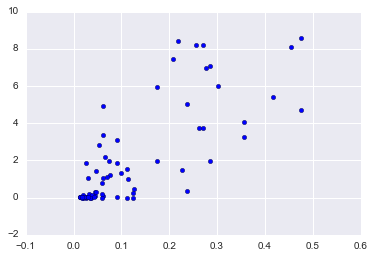

In [17]:
plt.scatter(processed_df.dropna()['Inverse Infant Mortality Rate'],
            processed_df.dropna()['Factor 8 IU per capita'], 
            )

# Feature Selection

At this point, our available data for training (before train-test-split) is very small. We need to further shorten the feature list.

## SelectKBest

In [18]:
cols = [
        'Deaths per 1,000 Population',
        'Net Migration Rate per 1,000',
        'Population mid-2015 (millions)', 
        'Inverse Infant Mortality Rate',
        'GNI per Capita ($US) 2014c',
        'Percent Urban'
        ]

features = processed_df.dropna()[cols]
target = processed_df.dropna()['Factor 8 IU per capita']
selector = SelectKBest(k=2)
selector.fit(features,target)

for i in range(len(features.columns)):
    print '{}: {}'.format(features.columns[i],selector.scores_[i])

Deaths per 1,000 Population: 1.7511662531
Net Migration Rate per 1,000: 2.19609239849
Population mid-2015 (millions): 0.999031976213
Inverse Infant Mortality Rate: 13.1702993385
GNI per Capita ($US) 2014c: 11.3317004661
Percent Urban: 1.00987000481


Seems like the two features "Inverse Infant Mortality Rate" and "GNI per Capita ($US) 2014c" won.

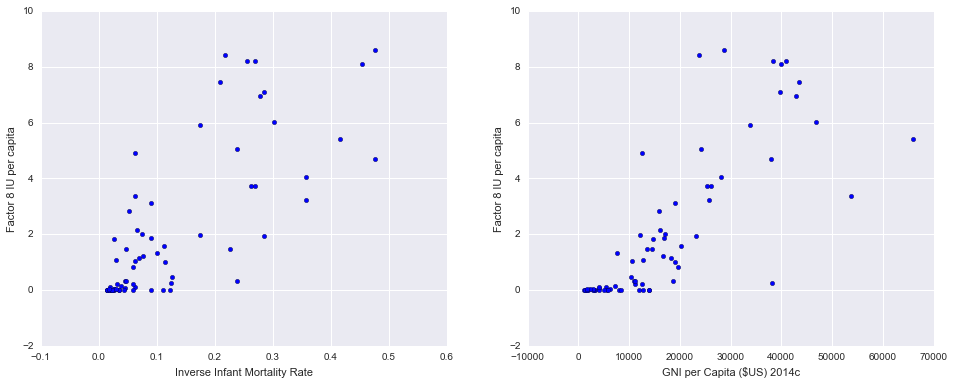

In [19]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.scatter(processed_df.dropna()['Inverse Infant Mortality Rate'],
            processed_df.dropna()['Factor 8 IU per capita'])
plt.xlabel('Inverse Infant Mortality Rate')
plt.ylabel('Factor 8 IU per capita')

plt.subplot(122)
plt.scatter(processed_df.dropna()['GNI per Capita ($US) 2014c'],
            processed_df.dropna()['Factor 8 IU per capita'])
plt.xlabel('GNI per Capita ($US) 2014c')
plt.ylabel('Factor 8 IU per capita')

# Training the Linear Regression Model

In [20]:
print 'Data available for train-test-split:',len(processed_df.dropna())
print 'Gaps I need to fill:',len(processed_df) - len(processed_df.dropna())

Data available for train-test-split: 70
Gaps I need to fill: 114


That's not much, but that's all there is available to me. Just have to ***very carefully*** explain to my stakeholders regarding the accuracy of the output.

In [29]:
features = processed_df.dropna()[['Inverse Infant Mortality Rate',
                                  'GNI per Capita ($US) 2014c'
                                 ]]
target = processed_df.dropna()['Factor 8 IU per capita']

x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.5, 
                                                    random_state=1)

Training results:
Coefficients: [  1.11305131e+01   4.74133593e-05]
R-Squared: 0.752168484104
Mean Absolute Error: 0.923432721035
Mean Squared Error: 1.61778238708

Test results:
R-Squared of test data: 0.587231121302
Mean Absolute Error: 1.34604899424
Mean Squared Error: 3.06289295363


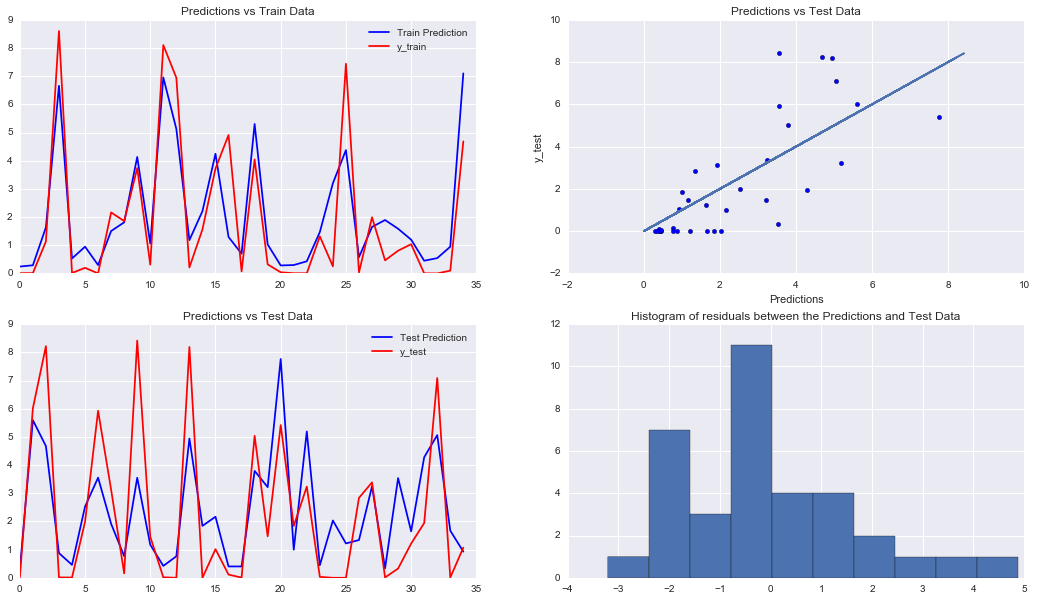

In [30]:
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(x_train,y_train)

train_pred = model.predict(x_train)
test_pred = model.predict(x_test)
residuals = (y_test - test_pred)

print 'Training results:'
print 'Coefficients:',model.coef_
print 'R-Squared:',model.score(x_train,y_train)
print 'Mean Absolute Error:', metrics.mean_absolute_error(y_train,train_pred)
print 'Mean Squared Error:', metrics.mean_squared_error(y_train,train_pred)

print ''
print 'Test results:'
print 'R-Squared of test data:', model.score(x_test,y_test)
print 'Mean Absolute Error:', metrics.mean_absolute_error(y_test,test_pred)
print 'Mean Squared Error:', metrics.mean_squared_error(y_test,test_pred)


figure, axes = plt.subplots(nrows=2,ncols=2, figsize=(18,10))

axes[0,0].plot(train_pred,'b',label='Train Prediction')
axes[0,0].plot(y_train.values,'r',label='y_train')
axes[0,0].set_title('Predictions vs Train Data')
axes[0,0].legend()


axes[1,0].plot(test_pred,'b',label='Test Prediction')
axes[1,0].plot(y_test.values,'r',label='y_test')
axes[1,0].set_title('Predictions vs Test Data')
axes[1,0].legend()

axes[0,1].set_title('Predictions vs Test Data')
axes[0,1].scatter(x=test_pred,y=y_test)
axes[0,1].set_xlabel('Predictions')
axes[0,1].set_ylabel('y_test')
axes[0,1].plot(y_test,y_test)

axes[1,1].hist(residuals)
axes[1,1].set_title('Histogram of residuals between the Predictions and Test Data')

The predictions are not ideal. But there are only around 70 data points to work with, so I can't use too many features to train the model or else I might risk overfitting.

In [23]:
cv_generator = ShuffleSplit(len(features),n_iter=20,test_size=.5,random_state=1)
cv_scores = cross_val_score(linear_model.LinearRegression(),X=features,y=target,cv=cv_generator)
cv_scores.mean()

0.57435765527535987

The CV score seems to be in line with our train-test data.

## PCA Transform
Let's get transformed data to see which data set performs better in Linear Regression. The idea is that PCA will include aspects from all 6 of our features, whereas SelectKBest simply drops 4 of our features.

In [24]:
# Loading our x_train - y_test data
cols = [
        'Deaths per 1,000 Population',
        'Net Migration Rate per 1,000',
        'Population mid-2015 (millions)', 
        'Inverse Infant Mortality Rate',
        'GNI per Capita ($US) 2014c',
        'Percent Urban'
        ]

features = processed_df.dropna()[cols]
target = processed_df.dropna()['Factor 8 IU per capita']

# PCA works best with scaled data
scaler = MinMaxScaler()
scaler.fit(features)
features = scaler.transform(features)
x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.5, 
                                                    random_state=1)

In [25]:
# PCA transforming our train/test features
pca = PCA(n_components=3)
pca.fit(x_train)

print pca.explained_variance_ratio_

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

[ 0.49217092  0.22128902  0.14509878]


With 3 components, I'm covering about 85% of the variance. While it's not ideal, I can't include more components because I just don't have enough data.

Training results:
Coefficients: [-5.1862805  -2.32174546  0.20789696]
R-Squared: 0.180713137952
Mean Absolute Error: 1.97218900042
Mean Squared Error: 5.34810050528

Test results:
R-Squared of test data: 0.108699451825
Mean Absolute Error: 2.0188090803
Mean Squared Error: 6.61376937424


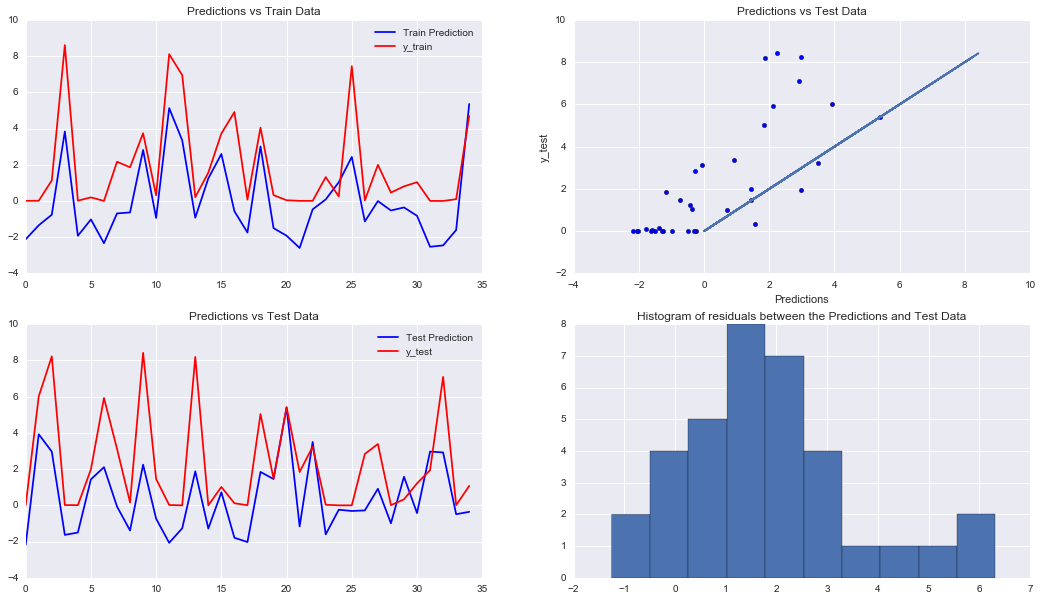

In [26]:
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(x_train_pca,y_train)

train_pred = model.predict(x_train_pca)
test_pred = model.predict(x_test_pca)
residuals = (y_test - test_pred)

print 'Training results:'
print 'Coefficients:',model.coef_
print 'R-Squared:',model.score(x_train_pca,y_train)
print 'Mean Absolute Error:', metrics.mean_absolute_error(y_train,train_pred)
print 'Mean Squared Error:', metrics.mean_squared_error(y_train,train_pred)

print ''
print 'Test results:'
print 'R-Squared of test data:', model.score(x_test_pca,y_test)
print 'Mean Absolute Error:', metrics.mean_absolute_error(y_test,test_pred)
print 'Mean Squared Error:', metrics.mean_squared_error(y_test,test_pred)


figure, axes = plt.subplots(nrows=2,ncols=2, figsize=(18,10))

axes[0,0].plot(train_pred,'b',label='Train Prediction')
axes[0,0].plot(y_train.values,'r',label='y_train')
axes[0,0].set_title('Predictions vs Train Data')
axes[0,0].legend()


axes[1,0].plot(test_pred,'b',label='Test Prediction')
axes[1,0].plot(y_test.values,'r',label='y_test')
axes[1,0].set_title('Predictions vs Test Data')
axes[1,0].legend()

axes[0,1].set_title('Predictions vs Test Data')
axes[0,1].scatter(x=test_pred,y=y_test)
axes[0,1].set_xlabel('Predictions')
axes[0,1].set_ylabel('y_test')
axes[0,1].plot(y_test,y_test)

axes[1,1].hist(residuals)
axes[1,1].set_title('Histogram of residuals between the Predictions and Test Data')

Obviously SelectKBest worked better with this data set. Let's use the Linear Regression model to predict the values.

# Using model to forecast
The model is used to predict the missing values in our target column.

**Be sure to load the correct model from above before running the following code.**

In [31]:
print 'Gaps in my data set I am trying to fill:',len(processed_df) - len(processed_df.dropna())

Gaps in my data set I am trying to fill: 114


In [32]:
features = processed_df[['Inverse Infant Mortality Rate',
                         'GNI per Capita ($US) 2014c'
                        ]]

predictions = model.predict(features)

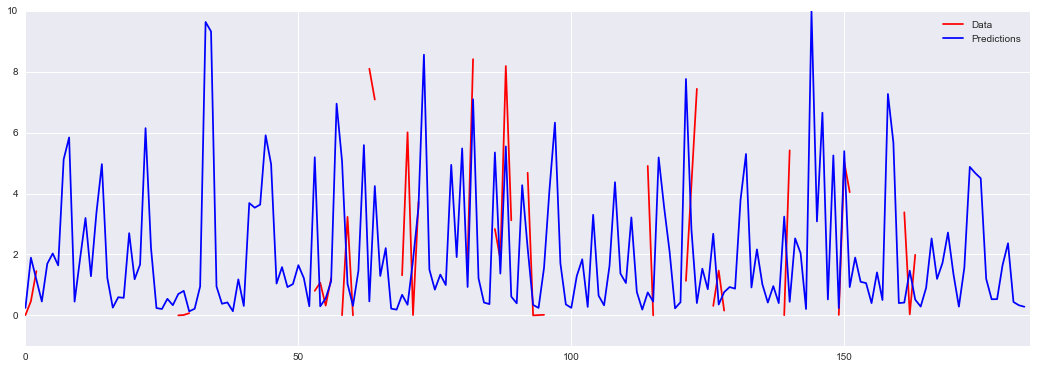

In [33]:
plt.figure(figsize=(18,6))
plt.plot(processed_df['Factor 8 IU per capita'],'r',label='Data')
plt.plot(predictions,'b',label='Predictions')
plt.xlim(xmax=len(predictions))
plt.ylim(ymin=-1)
plt.legend()


Note that our data has a lot of "gaps" in between, and that's what the model is trying to create predictions for to fill in these "gaps".

In [34]:
final_df = processed_df

In [35]:
final_df['Predictions'] = predictions

Let's see how my final model's prediction compare with available y_true!

R-Squared: 0.666197189414
Mean Absolute Error: 1.13474085764
Mean Squared Error: 2.34033767035


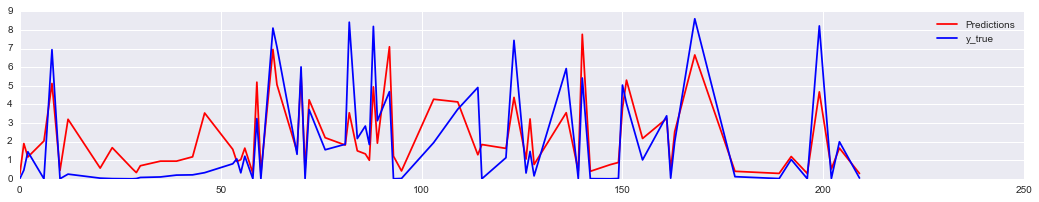

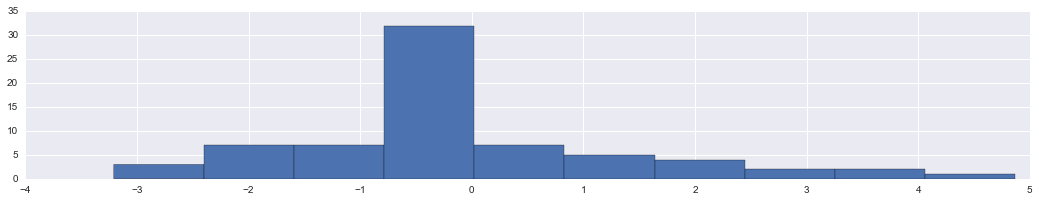

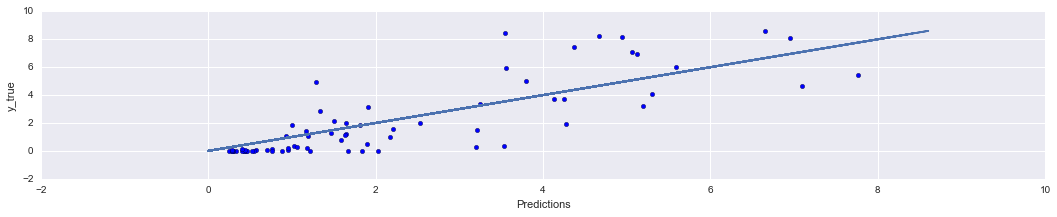

In [36]:
chart_predictions = final_df.dropna(subset=['Factor 8 IU per capita'])['Predictions']
y_true = final_df.dropna(subset=['Factor 8 IU per capita'])['Factor 8 IU per capita']
residuals = y_true - chart_predictions

print 'R-Squared:', metrics.r2_score(y_true,chart_predictions)
print 'Mean Absolute Error:', metrics.mean_absolute_error(y_true,chart_predictions)
print 'Mean Squared Error:', metrics.mean_squared_error(y_true,chart_predictions)

plt.figure(figsize=(18,3))
plt.plot(chart_predictions,'r',label='Predictions')
plt.plot(y_true,'b',label='y_true')
plt.legend()

plt.figure(figsize=(18,3))
plt.hist(residuals)

plt.figure(figsize=(18,3))
plt.scatter(x=chart_predictions,y=y_true)
plt.plot(y_true,y_true)
plt.xlabel('Predictions')
plt.ylabel('y_true')